In [1]:
gene_familly = "AP2"

In [2]:
# Parameters
gene_familly = "ARR-B"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA, DNA_MPI
from visualization import VISU, VISUReport
from feature_selection import SelectKFeature

[MacBook-Pro-de-Genereux.local:52132] shmem: mmap: an error occurred while determining whether or not /var/folders/w8/b_cflrn97k9c15rcrn5t8mmr0000gn/T//ompi.MacBook-Pro-de-Genereux.501/jf.0/3520200704/sm_segment.MacBook-Pro-de-Genereux.501.d1d20000.0 could be created.


In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE
gene_info_path = "../data/gene_info_small.json"
trainset_path  = "../data/mix_data/trainset/"
testset_path   = "../data/mix_data/testset/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

# FOCUS ON GENE FAMALLY
gene_dict = gene_info[gene_familly]
df_path = trainset_path+gene_dict['file_code']+".csv"
ts_path = testset_path+gene_dict['file_code']+".csv"

#LOAD DF
USE_FULL_DF = True
if USE_FULL_DF:
    dataset = pd.read_csv(df_path)
    testset = pd.read_csv(ts_path)
else:
    dataset_ = pd.read_csv(df_path)
    testset = pd.read_csv(ts_path)
    r = min(5000/len(dataset_), 1)
    _, dataset = train_test_split(dataset_, test_size=r, stratify=dataset_['class'], random_state=42)

In [6]:
dataset.head()

,Unnamed: 0,id,sequence,length,class
0,3403,GSBRNA2T00097086001,MATSGNGTTAGTGSPCGACKFLRRKCASDCIFAPYFSSEQGAARFA...,245,0
1,69,Aqcoe2G282600.1.p,MLNMDSGGGGTSKKASGDGVSDQFPAGLRVLVVDDDPTCLKILEKM...,696,1
2,4454,KHN26204.1,MPLYELYRLAREKLGKETTSTRAPDLCSSPENDFFELVWENGQISS...,722,0
3,1813,PSME_00040234-RA,MATVQSLQHSSISTASSLPSDSLGVFDENSGFNEQSRFPNQFPAGL...,285,1
4,1636,Phvul.001G258000.2,MPDMDGFKLLEHVGLEMDLPVIMMSVDGETSRVMKGVQHGACDYLL...,485,1


In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3741 entries, 0 to 3740
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  3741 non-null   int64 
 1   id          3741 non-null   object
 2   sequence    3741 non-null   object
 3   length      3741 non-null   int64 
 4   class       3741 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 146.3+ KB


In [8]:
#sns.set(style="whitegrid")
#sns.violinplot(x=dataset.length)
#plt.title("sequence length distribution in test sequences")
#plt.show()

In [9]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [10]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model-ft/"+gene_familly_+"/"+model_name+".keras", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=False
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [11]:
21**2

441

In [12]:
k        = 2
size     = int(len(dataset))
selector = SelectKFeature(dataset, k_feature=200, kmer_size=k, domaine=domaine, sample_size=size, discriminative=None)
mask     = selector.get_feature_mask(method=['f_test', 0.1])

In [13]:
X_train, y_train, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
X_test, y_test, _ = DNA.build_kmer_representation_v2(testset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
X_test.head()

,AA,AE,AG,AH,AK,AN,AP,AQ,AR,AT,...,WV,YA,YC,YF,YG,YK,YL,YV,YW,YY
0,0.001771,0.009743,0.003543,0.000000,0.000886,0.002657,0.003543,0.004429,0.000886,0.000886,...,0.0,0.000000,0.0,0.002657,0.000000,0.000886,0.000886,0.002657,0.0,0.001771
1,0.000000,0.000000,0.000000,0.000000,0.004367,0.004367,0.004367,0.000000,0.000000,0.000000,...,0.0,0.004367,0.0,0.000000,0.000000,0.000000,0.004367,0.004367,0.0,0.000000
2,0.012174,0.003478,0.000000,0.001739,0.001739,0.005217,0.005217,0.000000,0.001739,0.008696,...,0.0,0.000000,0.0,0.000000,0.001739,0.000000,0.000000,0.000000,0.0,0.001739
3,0.056738,0.003546,0.010638,0.000000,0.000000,0.000000,0.014184,0.007092,0.003546,0.007092,...,0.0,0.000000,0.0,0.000000,0.003546,0.000000,0.003546,0.000000,0.0,0.010638
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.009615,0.000000,0.0,0.000000


In [14]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (3741, 200)
X_test: (936, 200)
y_train: (3741,)
y_test: (936,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [15]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        51,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,721 (370.00 KB)

 Trainable params: 94,721 (370.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 35s 775ms/step - accuracy: 0.4531 - loss: 0.6934

28/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5611 - loss: 0.6864   

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6203 - loss: 0.6673 - val_accuracy: 0.9613 - val_loss: 0.3424


Epoch 2/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.3457

31/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9640 - loss: 0.2427 

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9637 - loss: 0.2129 - val_accuracy: 0.9613 - val_loss: 0.0950


Epoch 3/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9688 - loss: 0.0721

32/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9707 - loss: 0.0752 

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9710 - loss: 0.0763 - val_accuracy: 0.9773 - val_loss: 0.0722


Epoch 4/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9375 - loss: 0.1308

31/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9727 - loss: 0.0730 

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9739 - loss: 0.0694 - val_accuracy: 0.9800 - val_loss: 0.0620


Epoch 5/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9531 - loss: 0.0810

30/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9768 - loss: 0.0569 

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9796 - loss: 0.0525 - val_accuracy: 0.9746 - val_loss: 0.0772


Epoch 6/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9688 - loss: 0.0990

30/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9816 - loss: 0.0485 

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9830 - loss: 0.0446 - val_accuracy: 0.9826 - val_loss: 0.0495


Epoch 7/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0112

30/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9914 - loss: 0.0257 

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9901 - loss: 0.0298 - val_accuracy: 0.9853 - val_loss: 0.0489


Epoch 8/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0182

32/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9901 - loss: 0.0280 

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9889 - loss: 0.0300 - val_accuracy: 0.9813 - val_loss: 0.0474


Epoch 9/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0143

30/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9951 - loss: 0.0192 

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9938 - loss: 0.0209 - val_accuracy: 0.9840 - val_loss: 0.0453


Epoch 10/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0051

30/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9932 - loss: 0.0274 

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9919 - loss: 0.0288 - val_accuracy: 0.9786 - val_loss: 0.0579


Epoch 11/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0348

29/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9899 - loss: 0.0270 

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9895 - loss: 0.0271 - val_accuracy: 0.9546 - val_loss: 0.1325


Epoch 12/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9531 - loss: 0.1596

32/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9833 - loss: 0.0469 

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9861 - loss: 0.0397 - val_accuracy: 0.9813 - val_loss: 0.0467


Epoch 13/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0021

30/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9900 - loss: 0.0273 

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9906 - loss: 0.0261 - val_accuracy: 0.9866 - val_loss: 0.0428


Epoch 14/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0026

29/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9962 - loss: 0.0124 

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9963 - loss: 0.0121 - val_accuracy: 0.9826 - val_loss: 0.0486


Epoch 15/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0021

30/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9961 - loss: 0.0137 

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9947 - loss: 0.0159 - val_accuracy: 0.9813 - val_loss: 0.0598


Epoch 16/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0216

29/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9905 - loss: 0.0202 

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9920 - loss: 0.0179 - val_accuracy: 0.9813 - val_loss: 0.0551


Epoch 17/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9844 - loss: 0.0182

28/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9946 - loss: 0.0109 

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9952 - loss: 0.0107 - val_accuracy: 0.9840 - val_loss: 0.0514


Epoch 18/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 8.1207e-04

30/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9999 - loss: 0.0028     

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9997 - loss: 0.0032 - val_accuracy: 0.9840 - val_loss: 0.0493


Epoch 19/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.1233

29/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9968 - loss: 0.0218 

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9974 - loss: 0.0164 - val_accuracy: 0.9866 - val_loss: 0.0480


Epoch 20/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 6.3361e-04

31/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9997 - loss: 0.0039     

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0045 - val_accuracy: 0.9813 - val_loss: 0.0580


Epoch 21/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 9.0009e-04

30/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0023     

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9997 - loss: 0.0034 - val_accuracy: 0.9813 - val_loss: 0.0678


Epoch 22/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0241

29/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9955 - loss: 0.0120 

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9958 - loss: 0.0116 - val_accuracy: 0.9853 - val_loss: 0.0558


Epoch 23/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 8.5504e-04

28/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0061     

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0061 - val_accuracy: 0.9826 - val_loss: 0.0593



[Train Accuracy: 99.93% - Test Accuracy: 98.29%]


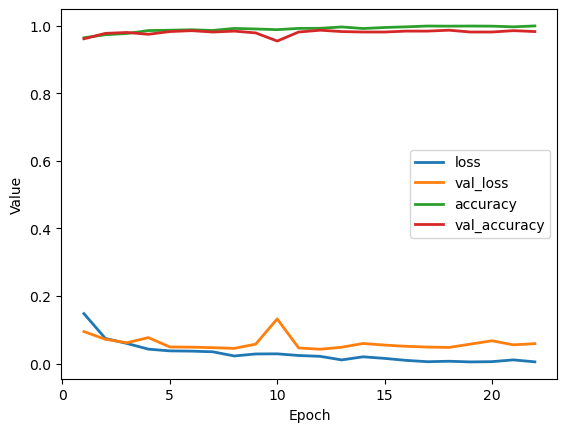

In [16]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [17]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k2, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/30 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 1/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [18]:
21**3

9261

In [19]:
k        = 3
size     = int(len(dataset))
selector = SelectKFeature(dataset, k_feature=1000, kmer_size=k, domaine=domaine, sample_size=size, discriminative=None)
mask     = selector.get_feature_mask(method=['rf', 0.1])

In [20]:
X_train, y_train, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
X_test, y_test, _ = DNA.build_kmer_representation_v2(testset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
X_test.head()

,QHV,PVI,QKY,WQH,DLP,NVA,LQK,MNV,RVL,AVP,...,SHR,VQK,KCM,NEE,LAF,RKR,QLP,LAD,LYI,ISC
0,0.0,0.000887,0.0,0.000887,0.000887,0.0,0.000887,0.0,0.000887,0.000000,...,0.0,0.0,0.0,0.001773,0.0,0.0,0.000000,0.000887,0.0,0.0
1,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
2,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.001742,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.001742,0.000000,0.0,0.0
3,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.003559,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
4,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0


In [21]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (3741, 1000)
X_test: (936, 1000)
y_train: (3741,)
y_test: (936,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [22]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 256)            │       256,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 299,521 (1.14 MB)

 Trainable params: 299,521 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 32s 702ms/step - accuracy: 0.6250 - loss: 0.6931

20/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5414 - loss: 0.6916   

41/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6135 - loss: 0.6828

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6370 - loss: 0.6760 - val_accuracy: 0.9626 - val_loss: 0.3771


Epoch 2/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9688 - loss: 0.3935

20/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9725 - loss: 0.2860 

40/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9714 - loss: 0.2292

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9713 - loss: 0.2144 - val_accuracy: 0.9813 - val_loss: 0.0563


Epoch 3/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9688 - loss: 0.1165

19/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9890 - loss: 0.0477 

38/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9911 - loss: 0.0390

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9916 - loss: 0.0369 - val_accuracy: 0.9933 - val_loss: 0.0214


Epoch 4/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0142

19/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9970 - loss: 0.0132 

37/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9953 - loss: 0.0163

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9951 - loss: 0.0165 - val_accuracy: 0.9907 - val_loss: 0.0243


Epoch 5/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9844 - loss: 0.0330

18/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9937 - loss: 0.0145 

37/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9951 - loss: 0.0124

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9955 - loss: 0.0120 - val_accuracy: 0.9960 - val_loss: 0.0145


Epoch 6/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0044

19/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9989 - loss: 0.0047 

38/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9983 - loss: 0.0059

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9980 - loss: 0.0068 - val_accuracy: 0.9947 - val_loss: 0.0134


Epoch 7/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0017

20/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9975 - loss: 0.0070 

39/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9979 - loss: 0.0070

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9981 - loss: 0.0068 - val_accuracy: 0.9880 - val_loss: 0.0309


Epoch 8/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0028

19/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0028 

38/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9994 - loss: 0.0037

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9992 - loss: 0.0040 - val_accuracy: 0.9933 - val_loss: 0.0157


Epoch 9/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 4.7937e-04

19/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9983 - loss: 0.0040     

37/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9989 - loss: 0.0032

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9990 - loss: 0.0029 - val_accuracy: 0.9933 - val_loss: 0.0158


Epoch 10/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0024

19/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0014 

37/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 0.0012

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9998 - loss: 0.0012 - val_accuracy: 0.9920 - val_loss: 0.0236


Epoch 11/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 8.5877e-04

19/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 8.9390e-04 

38/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 0.0011    

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9998 - loss: 0.0014 - val_accuracy: 0.9933 - val_loss: 0.0172


Epoch 12/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 6.6346e-04

19/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0011     

37/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 9.2945e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 8.8756e-04 - val_accuracy: 0.9947 - val_loss: 0.0161


Epoch 13/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0022

19/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 9.1331e-04

37/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 7.2107e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 6.6500e-04 - val_accuracy: 0.9960 - val_loss: 0.0154


Epoch 14/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 2.5576e-04

18/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.4649e-04 

36/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.8536e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.9034e-04 - val_accuracy: 0.9920 - val_loss: 0.0209


Epoch 15/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 4.7423e-04

19/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.9461e-04 

37/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.4586e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.2101e-04 - val_accuracy: 0.9947 - val_loss: 0.0160



[Train Accuracy: 100.00% - Test Accuracy: 99.25%]


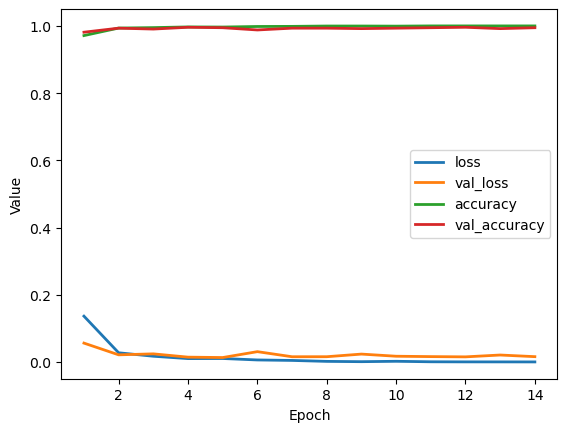

In [23]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [24]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k3, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/30 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 1/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [25]:
21**4

194481

In [26]:
k        = 4
size     = int(len(dataset))
selector = SelectKFeature(dataset, k_feature=1000, kmer_size=k, domaine=domaine, sample_size=size, discriminative=None)
mask     = selector.get_feature_mask(method=['f_test', 0.1])

In [27]:
X_train, y_train, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
X_test, y_test, _ = DNA.build_kmer_representation_v2(testset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y) #, random_state=42
X_test.head()

,AAAA,AAAT,AAAV,AALG,AARA,AAVN,ACDY,ADAW,ADDS,ADYS,...,YPPY,YPQN,YPVW,YQVT,YRGV,YRIF,YRIY,YRLY,YRMH,YYPH
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.017857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [29]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 256)            │       256,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 297,473 (1.13 MB)

 Trainable params: 297,473 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 26s 579ms/step - accuracy: 0.5469 - loss: 0.6931

20/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5814 - loss: 0.6911   

41/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6424 - loss: 0.6809

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6595 - loss: 0.6740 - val_accuracy: 0.8879 - val_loss: 0.4017


Epoch 2/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8281 - loss: 0.4368

24/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8965 - loss: 0.3401 

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9108 - loss: 0.2900 - val_accuracy: 0.9586 - val_loss: 0.1045


Epoch 3/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9531 - loss: 0.1521

21/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9618 - loss: 0.1111 

42/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9646 - loss: 0.1058

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9650 - loss: 0.1049 - val_accuracy: 0.9800 - val_loss: 0.0658


Epoch 4/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9531 - loss: 0.1108

21/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9755 - loss: 0.0800 

42/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9760 - loss: 0.0787

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9764 - loss: 0.0778 - val_accuracy: 0.9866 - val_loss: 0.0620


Epoch 5/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0175

22/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9877 - loss: 0.0446 

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9856 - loss: 0.0497

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9853 - loss: 0.0508 - val_accuracy: 0.9813 - val_loss: 0.0555


Epoch 6/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9375 - loss: 0.1683

21/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9800 - loss: 0.0615 

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9820 - loss: 0.0554

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9821 - loss: 0.0550 - val_accuracy: 0.9826 - val_loss: 0.0437


Epoch 7/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9844 - loss: 0.0627

21/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9862 - loss: 0.0550 

42/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9863 - loss: 0.0536

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9864 - loss: 0.0528 - val_accuracy: 0.9853 - val_loss: 0.0418


Epoch 8/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0065

21/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9912 - loss: 0.0346 

42/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9901 - loss: 0.0362

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9898 - loss: 0.0366 - val_accuracy: 0.9840 - val_loss: 0.0508


Epoch 9/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9688 - loss: 0.0444

21/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9830 - loss: 0.0358 

42/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9863 - loss: 0.0341

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9868 - loss: 0.0338 - val_accuracy: 0.9853 - val_loss: 0.0432


Epoch 10/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0176

21/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9926 - loss: 0.0304 

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9934 - loss: 0.0268

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9934 - loss: 0.0267 - val_accuracy: 0.9826 - val_loss: 0.0435


Epoch 11/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0639

22/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9925 - loss: 0.0278 

44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9936 - loss: 0.0247

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9937 - loss: 0.0244 - val_accuracy: 0.9866 - val_loss: 0.0356


Epoch 12/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0166

21/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9944 - loss: 0.0212 

42/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9936 - loss: 0.0214

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9936 - loss: 0.0211 - val_accuracy: 0.9853 - val_loss: 0.0379


Epoch 13/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0080

22/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9935 - loss: 0.0188 

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9936 - loss: 0.0190

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9937 - loss: 0.0188 - val_accuracy: 0.9853 - val_loss: 0.0354


Epoch 14/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0037

22/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0083 

41/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9978 - loss: 0.0113

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9976 - loss: 0.0117 - val_accuracy: 0.9907 - val_loss: 0.0371


Epoch 15/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0104

21/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9944 - loss: 0.0217 

42/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9947 - loss: 0.0204

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9947 - loss: 0.0202 - val_accuracy: 0.9840 - val_loss: 0.0353


Epoch 16/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0038

21/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9968 - loss: 0.0133 

41/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9967 - loss: 0.0134

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9967 - loss: 0.0136 - val_accuracy: 0.9813 - val_loss: 0.0515


Epoch 17/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0024

22/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9978 - loss: 0.0087 

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9974 - loss: 0.0095

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9973 - loss: 0.0095 - val_accuracy: 0.9840 - val_loss: 0.0445


Epoch 18/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0020

21/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9980 - loss: 0.0063 

41/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9964 - loss: 0.0100

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9960 - loss: 0.0108 - val_accuracy: 0.9786 - val_loss: 0.0644


Epoch 19/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0087

21/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9980 - loss: 0.0070 

41/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9986 - loss: 0.0060

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9986 - loss: 0.0061 - val_accuracy: 0.9826 - val_loss: 0.0476


Epoch 20/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9844 - loss: 0.0165

21/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9929 - loss: 0.0129 

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9942 - loss: 0.0129

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9944 - loss: 0.0127 - val_accuracy: 0.9826 - val_loss: 0.0494


Epoch 21/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0015

21/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9997 - loss: 0.0027 

41/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9994 - loss: 0.0041

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - loss: 0.0043 - val_accuracy: 0.9786 - val_loss: 0.0629


Epoch 22/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0034

22/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9975 - loss: 0.0098 

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9974 - loss: 0.0098

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9975 - loss: 0.0096 - val_accuracy: 0.9840 - val_loss: 0.0456


Epoch 23/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 7.5263e-04

21/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9990 - loss: 0.0021     

42/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0040

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9986 - loss: 0.0042 - val_accuracy: 0.9813 - val_loss: 0.0534


Epoch 24/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9844 - loss: 0.0353

21/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9957 - loss: 0.0111 

42/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9971 - loss: 0.0081

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9973 - loss: 0.0077 - val_accuracy: 0.9800 - val_loss: 0.0626



[Train Accuracy: 99.90% - Test Accuracy: 99.04%]


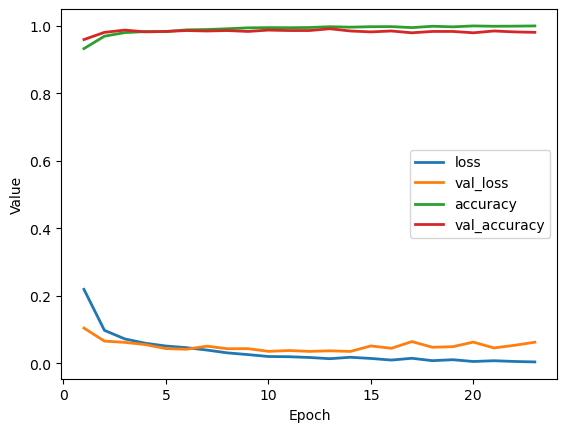

In [30]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [31]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k4, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/30 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 1/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


In [32]:
#report.save()

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [33]:
21**5

4084101

In [34]:
k        = 5
size     = int(len(dataset))
selector = SelectKFeature(dataset, k_feature=1000, kmer_size=k, domaine=domaine, sample_size=min(1300/len(dataset), 1), discriminative=None)
mask     = selector.get_feature_mask(method=['f_test', 0.00001]);

In [35]:
k = 5
X_train, y_train, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
X_test, y_test, _ = DNA.build_kmer_representation_v2(testset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y) #, random_state=42
X_test.head()

,AAAAA,AAEIK,AAGLG,AALGG,AASGQ,AAVNQ,ACDYL,ADAWG,ADDGK,ADDSK,...,YLSRL,YLVKP,YNVTT,YPAPS,YPMWG,YQVTT,YRIFL,YRLYL,YRMHR,YSSSA
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.010753,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [37]:
name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 512)            │       512,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 586,497 (2.24 MB)

 Trainable params: 586,497 (2.24 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 26s 584ms/step - accuracy: 0.5938 - loss: 0.6932

16/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5327 - loss: 0.6921   

33/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5293 - loss: 0.6886

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5605 - loss: 0.6791 - val_accuracy: 0.9479 - val_loss: 0.4545


Epoch 2/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8906 - loss: 0.4815

16/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9020 - loss: 0.4178 

32/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9059 - loss: 0.3733

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9112 - loss: 0.3391 - val_accuracy: 0.9146 - val_loss: 0.1978


Epoch 3/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9062 - loss: 0.2246

16/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9367 - loss: 0.1783 

32/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9408 - loss: 0.1711

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9432 - loss: 0.1659

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9436 - loss: 0.1652 - val_accuracy: 0.9292 - val_loss: 0.2007


Epoch 4/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9375 - loss: 0.1293

13/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9594 - loss: 0.1068 

25/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9574 - loss: 0.1220

35/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9564 - loss: 0.1251

45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9562 - loss: 0.1258

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9562 - loss: 0.1258 - val_accuracy: 0.9626 - val_loss: 0.1254


Epoch 5/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9844 - loss: 0.1086

 9/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9686 - loss: 0.1067 

19/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9643 - loss: 0.1109

28/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9646 - loss: 0.1110

42/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9652 - loss: 0.1111

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9654 - loss: 0.1110 - val_accuracy: 0.9559 - val_loss: 0.1315


Epoch 6/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9531 - loss: 0.0765

16/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9595 - loss: 0.0892 

30/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9635 - loss: 0.0923

44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9645 - loss: 0.0947

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9646 - loss: 0.0951 - val_accuracy: 0.9626 - val_loss: 0.1158


Epoch 7/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9531 - loss: 0.0912

15/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9639 - loss: 0.0979 

29/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9651 - loss: 0.0993

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9660 - loss: 0.0973

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9662 - loss: 0.0971 - val_accuracy: 0.9653 - val_loss: 0.1070


Epoch 8/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9531 - loss: 0.1373

15/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9614 - loss: 0.1037 

30/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9655 - loss: 0.0972

44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9676 - loss: 0.0931

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9680 - loss: 0.0926 - val_accuracy: 0.9666 - val_loss: 0.1010


Epoch 9/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9844 - loss: 0.0529

14/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9863 - loss: 0.0608 

28/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9809 - loss: 0.0701

41/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9785 - loss: 0.0742

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9776 - loss: 0.0763 - val_accuracy: 0.9760 - val_loss: 0.0958


Epoch 10/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9844 - loss: 0.0715

15/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9794 - loss: 0.0646 

29/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9793 - loss: 0.0645

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9786 - loss: 0.0677

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9786 - loss: 0.0684 - val_accuracy: 0.9693 - val_loss: 0.0904


Epoch 11/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9844 - loss: 0.0445

15/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9777 - loss: 0.0600 

29/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9796 - loss: 0.0626

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9800 - loss: 0.0646

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9800 - loss: 0.0653 - val_accuracy: 0.9760 - val_loss: 0.0891


Epoch 12/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0322

14/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9829 - loss: 0.0570 

28/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9802 - loss: 0.0687

42/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9784 - loss: 0.0733

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9777 - loss: 0.0756 - val_accuracy: 0.9693 - val_loss: 0.0902


Epoch 13/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9844 - loss: 0.0687

15/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9844 - loss: 0.0709 

29/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9818 - loss: 0.0716

44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9811 - loss: 0.0706

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9810 - loss: 0.0703 - val_accuracy: 0.9706 - val_loss: 0.0854


Epoch 14/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9688 - loss: 0.0573

15/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9820 - loss: 0.0415 

29/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9839 - loss: 0.0429

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9838 - loss: 0.0460

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9839 - loss: 0.0465 - val_accuracy: 0.9666 - val_loss: 0.0987


Epoch 15/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9688 - loss: 0.0718

15/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9751 - loss: 0.0602 

29/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9786 - loss: 0.0596

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9798 - loss: 0.0588

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9801 - loss: 0.0584 - val_accuracy: 0.9786 - val_loss: 0.0711


Epoch 16/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9688 - loss: 0.1312

15/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9849 - loss: 0.0640 

29/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9856 - loss: 0.0568

44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9850 - loss: 0.0565

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9848 - loss: 0.0568 - val_accuracy: 0.9746 - val_loss: 0.0874


Epoch 17/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0065

14/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9893 - loss: 0.0386 

29/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9876 - loss: 0.0434

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9870 - loss: 0.0452

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9869 - loss: 0.0455 - val_accuracy: 0.9813 - val_loss: 0.0627


Epoch 18/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0150

14/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9902 - loss: 0.0422 

28/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9897 - loss: 0.0428

42/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9896 - loss: 0.0428

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9895 - loss: 0.0427 - val_accuracy: 0.9640 - val_loss: 0.1219


Epoch 19/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9844 - loss: 0.0587

14/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9801 - loss: 0.0755 

28/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9805 - loss: 0.0732

42/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9817 - loss: 0.0687

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9823 - loss: 0.0666 - val_accuracy: 0.9800 - val_loss: 0.0680


Epoch 20/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9844 - loss: 0.0491

15/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9887 - loss: 0.0459 

28/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9891 - loss: 0.0448

42/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9888 - loss: 0.0450

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9886 - loss: 0.0449 - val_accuracy: 0.9786 - val_loss: 0.1157


Epoch 21/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0893

15/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9872 - loss: 0.0645 

29/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9852 - loss: 0.0618

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9860 - loss: 0.0558

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9863 - loss: 0.0542 - val_accuracy: 0.9853 - val_loss: 0.0646


Epoch 22/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0063

15/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9936 - loss: 0.0193 

29/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9934 - loss: 0.0236

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9928 - loss: 0.0270

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9926 - loss: 0.0280 - val_accuracy: 0.9746 - val_loss: 0.0947


Epoch 23/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9688 - loss: 0.0947

15/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9805 - loss: 0.0718 

29/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9833 - loss: 0.0642

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9850 - loss: 0.0582

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9854 - loss: 0.0568 - val_accuracy: 0.9813 - val_loss: 0.0590


Epoch 24/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0134

15/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9938 - loss: 0.0328 

29/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9928 - loss: 0.0355

44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9927 - loss: 0.0341

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9927 - loss: 0.0338 - val_accuracy: 0.9813 - val_loss: 0.0585


Epoch 25/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9844 - loss: 0.0750

15/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9931 - loss: 0.0346 

30/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9924 - loss: 0.0352

45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9925 - loss: 0.0344

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9926 - loss: 0.0343 - val_accuracy: 0.9840 - val_loss: 0.0574


Epoch 26/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9844 - loss: 0.0480

15/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9928 - loss: 0.0304 

30/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9929 - loss: 0.0321

45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9931 - loss: 0.0316

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9932 - loss: 0.0314 - val_accuracy: 0.9786 - val_loss: 0.0755


Epoch 27/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9844 - loss: 0.0463

16/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9943 - loss: 0.0198 

30/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9939 - loss: 0.0235

44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9933 - loss: 0.0268

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9931 - loss: 0.0277 - val_accuracy: 0.9760 - val_loss: 0.0804


Epoch 28/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9844 - loss: 0.0395

15/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9834 - loss: 0.0394 

29/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9845 - loss: 0.0402

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9853 - loss: 0.0401

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9856 - loss: 0.0400 - val_accuracy: 0.9840 - val_loss: 0.0619


Epoch 29/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9688 - loss: 0.0738

15/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9855 - loss: 0.0474 

29/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9871 - loss: 0.0448

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9873 - loss: 0.0437

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9874 - loss: 0.0431 - val_accuracy: 0.9760 - val_loss: 0.0877


Epoch 30/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9844 - loss: 0.0283

15/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9885 - loss: 0.0442 

29/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9899 - loss: 0.0403

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9906 - loss: 0.0384

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9909 - loss: 0.0377 - val_accuracy: 0.9840 - val_loss: 0.0551


Epoch 31/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0099

15/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9963 - loss: 0.0137 

29/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9948 - loss: 0.0177

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9933 - loss: 0.0236

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9930 - loss: 0.0248 - val_accuracy: 0.9840 - val_loss: 0.0549



[Train Accuracy: 99.03% - Test Accuracy: 99.04%]


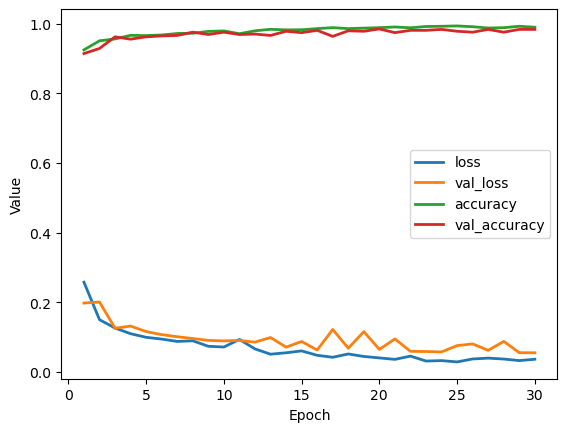

In [38]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [39]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
report.save('-ft')

 1/30 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 1/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step


Report saved as Output/Reports/ARR-B/report_full_1WM8OZAR.html


In [40]:
# END

In [41]:
######################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################